In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
import torch
from subject.braintreebank import BrainTreebankSubject
from subject.braintreebank_mne import MNEBraintreebankSubject, preprocess, extract_movie_metadata, words_to_events
mne.viz.set_browser_backend('matplotlib')  # safe, 2D-only, no OpenGL

import time
def elapsed(start):
    tdif = time.time() - start
    print("%.2fm elapsed"%(tdif/(60)))
    
# List movies and subjects by movie watched
movie_data = extract_movie_metadata("/om2/user/zaho/braintreebank/braintreebank/subject_metadata")
movie_df = pd.DataFrame(movie_data)
movie_df.groupby("title").apply(
        lambda g: list(zip(g["subject"], g["trial"]))
    ).reset_index(name="subject_trial_pairs")

Using matplotlib as 2D backend.


/tmp/ipykernel_1481397/1465992062.py:23: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  movie_df.groupby("title").apply(


,title,subject_trial_pairs
0,Antman,"[(9, 0)]"
1,Aquaman,"[(2, 6)]"
2,Avengers Infinity War,"[(2, 4)]"
3,Black Panther,"[(2, 5)]"
4,Cars 2,"[(10, 0), (3, 0), (7, 0)]"
5,Coraline,"[(6, 4)]"
6,Fantastic Mr. Fox,"[(1, 0), (5, 0)]"
7,Guardians Of The Galaxy 2,"[(2, 3)]"
8,Guardians Of the Galaxy,"[(2, 2)]"
9,Lord Of The Rings 1,"[(3, 1)]"


### Preprocess and store data for subjects watching the same movie

In [2]:
def resample_indices(indices, sfreq_from, sfreq_to, idx_start=0):
    indices = np.asarray(indices)
    scale = sfreq_to / sfreq_from
    indices = indices - idx_start
    new_indices = (indices * scale).round().astype(int)
    return new_indices

def label_epochs_by_event(epoch_starts, epoch_length, events_df, label_col='label', misc_label='misc'):
    labels = []

    for e_start in epoch_starts:
        e_end = e_start + epoch_length

        overlapping_events = events_df[
            (events_df['est_end_idx'] > e_start) & (events_df['est_idx'] < e_end)
        ]

        if overlapping_events.empty:
            labels.append(misc_label)
        else:
            overlap_durations = overlapping_events.apply(
                lambda row: min(row['est_end_idx'], e_end) - max(row['est_idx'], e_start),
                axis=1
            )
            max_overlap_idx = overlap_durations.idxmax()
            labels.append(overlapping_events.loc[max_overlap_idx, label_col])

    return np.array(labels)

FILT_POS = ["NOUN", "NUM", "VERB", "ADJ"]
def get_subject_data(subject_id, trial_id, t_from, t_to, sfreq, 
                     label_cols = ['pos', 'concept'], dt=0.5):
    subject = MNEBraintreebankSubject(subject_id=subject_id, allow_corrupted=False, cache=False)
    meta_dict, words_df, triggers = subject.get_trial_info(trial_id)

    # add feature
    word_counts = words_df["lemma"].value_counts()
    
    words_df["concept"] = words_df["lemma"]
    words_df.loc[~words_df['pos'].isin(FILT_POS),"concept"] = "other"
    rare_mask = words_df["lemma"].map(word_counts) > 0.02*sum(word_counts)
    rare_mask = rare_mask | (words_df["lemma"].map(word_counts) < 2)
    words_df.loc[rare_mask, "concept"] = "misc"

    events, events_dict = words_to_events(words_df, event_column = 'is_onset')

    # get data starting from beginning of movie 
    t0 = triggers[triggers['type']=='beginning']['index'].item()
    for col in ['est_idx', 'est_end_idx']:
        words_df[col] = resample_indices(words_df[col], 
                                         sfreq_from=subject.sfreq, sfreq_to=sfreq, idx_start=t0)
    
    raw = subject.get_trial_raw(trial_id, t_from = t_from, t_to = t_to, t0 = t0)
    raw = preprocess(raw, l_freq = 1, h_freq = 256) # notch/band-pass filter
    raw, events = raw.resample(sfreq=sfreq, events = events)
    """epochs = mne.Epochs(raw, events, event_id=events_dict, 
                    tmin = -0.1, tmax = 0.4, baseline = (None, 0), 
                    event_repeated = 'drop')"""
    
    epochs = mne.make_fixed_length_epochs(raw, duration=dt, 
                                          overlap=dt/2,
                                          preload=False)
    X = epochs.get_data()  # shape (n_epochs, n_channels, n_times)
    # Compute per-channel stats on the training set
    means = X.mean(axis=(0, 2), keepdims=True)   # shape (1, n_ch, 1)
    stds  = X.std(axis=(0, 2), keepdims=True)

    # Z-score
    X = (X - means) / (stds + 1e-6)
    #Y = epochs.events[:, -1]  # the event codes as target labels

    subject_dict = {
        "raw": raw,
        "triggers": triggers,
        "epochs": epochs,
        "events_dict": events_dict,
        "meta_dict": meta_dict,
        "words_df": words_df,
    }
    for label_col in label_cols:
        subject_dict[label_col] = label_epochs_by_event(epochs.events[:, 0], 
                                                        epochs.times.size, 
                                                        events_df = words_df, 
                                                        label_col = label_col)
        
    return X, subject_dict

# FILT_POS = ["NOUN", "NUM", "VERB", "ADJ"]
# subject_dict['words_df'][subject_dict['words_df']['pos'].isin(FILT_POS)]

# parameters
sfreq = 100
# get all data for cars 2
subject_trial_pairs = [("10", 0), ("3", 0), ("7", 0)] # 8min to load 1800s
data_df = {}
t0 = 10 * 60 # start 10 minutes in
for subject_id, trial_id in subject_trial_pairs:
    start = time.time()
    X, subject_dict = get_subject_data(subject_id, trial_id, 
                                       t_from = t0, t_to = t0 + 1200, 
                                       sfreq = sfreq)
    data_df[subject_id] = {
        "X": X,
        "info": subject_dict
    }
    elapsed(start)

Movie name for the given subject and trial is: Cars 2
Creating RawArray with float64 data, n_channels=207, n_times=2457600
    Range : 0 ... 2457599 =      0.000 ...  1200.000 secs
Ready.
sEEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('sEEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13517 samples (6.600 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    8.8s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   19.9s
[Parallel(n_jobs=1)]: Done 207 out of 207 | elapsed:   25.6s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 2.6e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 256.00 Hz
- Upper transition bandwidth: 64.00 Hz (-6 dB cutoff frequency: 288.00 Hz)
- Filter length: 6759 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    9.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   20.7s
[Parallel(n_jobs=1)]: Done 207 out of 207 | elapsed:   26.6s finished


Not setting metadata
4799 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 4799 events and 50 original time points ...
0 bad epochs dropped
3.78m elapsed
Movie name for the given subject and trial is: Cars 2
Creating RawArray with float64 data, n_channels=124, n_times=2457600
    Range : 0 ... 2457599 =      0.000 ...  1200.000 secs
Ready.
sEEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('sEEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13517 samples (6.600 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    8.8s
[Parallel(n_jobs=1)]: Done 124 out of 124 | elapsed:   15.4s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 2.6e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 256.00 Hz
- Upper transition bandwidth: 64.00 Hz (-6 dB cutoff frequency: 288.00 Hz)
- Filter length: 6759 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    9.0s
[Parallel(n_jobs=1)]: Done 124 out of 124 | elapsed:   15.7s finished


Not setting metadata
4799 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 4799 events and 50 original time points ...
0 bad epochs dropped
3.35m elapsed
Movie name for the given subject and trial is: Cars 2
Creating RawArray with float64 data, n_channels=240, n_times=2457600
    Range : 0 ... 2457599 =      0.000 ...  1200.000 secs
Ready.
sEEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('sEEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13517 samples (6.600 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    8.8s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   19.9s
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:   29.7s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 2.6e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 256.00 Hz
- Upper transition bandwidth: 64.00 Hz (-6 dB cutoff frequency: 288.00 Hz)
- Filter length: 6759 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    8.9s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   20.1s
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:   30.0s finished


Not setting metadata
4799 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 4799 events and 50 original time points ...
0 bad epochs dropped
4.52m elapsed


### Create dataset, define losses, and train model

In [42]:
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset

class EEGDataset(Dataset):
    def __init__(self, X, Y, subject_id: str, labels = {}):
        self.X = X     # (n_trials, n_ch, n_time)
        self.Y = Y   # or whatever labels you need
        self.subject_id = subject_id

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = torch.from_numpy(self.X[idx]).float()  # (n_ch, n_time)
        y = self.Y[idx]
        # We return the subject ID string alongside each sample
        return x, y, self.subject_id

class TemporalEEGDataset(Dataset):
    def __init__(self, datasets):
        self.samples = []
        self.time_to_indices = defaultdict(list)

        for dset in datasets:
            for i in range(len(dset.X)):
                time = float(dset.Y[i])
                subj = dset.subject_id
                x = torch.from_numpy(dset.X[i]).float()
                index = len(self.samples)
                self.samples.append((x, time, subj))
                self.time_to_indices[time].append(index)

        self.times = sorted(self.time_to_indices.keys())

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]  # (x, time, subj)


# 2.1. collate_fn to handle variable channel counts
    
from collections import defaultdict
def collate_eeg_by_subject(batch):
    """
    Groups samples by subject ID.

    batch: list of tuples (x, y, subject_id)
        - x: Tensor(n_ch_i, seq_len)
        - y: int
        - subject_id: str or int

    Returns:
        subject_batches: dict
            sid -> {
                'x': list of tensors (n_ch_i, seq_len),
                'y': list of labels
                'indices': list of indices in original batch
            }
    """
    subject_batches = defaultdict(lambda: {'x': [], 'y': [], 'indices': []})
    
    for idx, (x, y, sid) in enumerate(batch):
        subject_batches[sid]['x'].append(x)
        subject_batches[sid]['y'].append(y)
        subject_batches[sid]['indices'].append(idx)

    for sid in subject_batches:
        subject_batches[sid]['x'] = torch.stack(subject_batches[sid]['x'])
    return subject_batches

import random
class TimeSampler:
    def __init__(self, time_to_indices, times, num_timepoints=4, samples_per_time=4, delta=1):
        """
        time_to_indices: dict[time] → list of dataset indices
        times: sorted list of available times
        delta: window size for fuzzy sampling (e.g., ±1s)
        """
        self.time_to_indices = time_to_indices
        self.times = times
        self.num_timepoints = num_timepoints
        self.samples_per_time = samples_per_time
        self.delta = delta

    def __iter__(self):
        for _ in range(len(self)):
            batch_indices = []
            chosen_times = random.sample(self.times, self.num_timepoints)
            for anchor_time in chosen_times:
                # get neighboring times within delta
                neighbors = [t for t in self.times if abs(t - anchor_time) <= self.delta]
                nearby_indices = []
                for t in neighbors:
                    nearby_indices.extend(self.time_to_indices[t])
                if len(nearby_indices) >= self.samples_per_time:
                    batch_indices.extend(random.sample(nearby_indices, self.samples_per_time))
                else:
                    batch_indices.extend(nearby_indices)
            yield batch_indices

    def __len__(self):
        return len(self.times) // self.num_timepoints

def collate_eeg_by_time(batch):
    """
    batch: list of (x, time, subj)
    """
    xs, times, sids = zip(*batch)
    max_ch = max(x.shape[0] for x in xs)
    seq_len = xs[0].shape[1]
    padded = []
    for x in xs:
        if x.shape[0] < max_ch:
            pad = torch.zeros(max_ch - x.shape[0], seq_len)
            x = torch.cat([x, pad], dim=0)
        padded.append(x)

    x_batch = torch.stack(padded)  # (batch, max_ch, seq_len)
    t_batch = torch.tensor(times)
    return x_batch, t_batch, list(sids)



# Example: build a combined dataset for multiple subjects
batch_size = 512

datasets = [EEGDataset(X = data_df[subject_id]['X'], 
                       Y = data_df[subject_id]['info']['epochs'].events[:, 0], 
                       subject_id = subject_id) for subject_id in data_df.keys()]
dataset = TemporalEEGDataset(datasets)
sampler = TimeSampler(
    time_to_indices = dataset.time_to_indices,
    times = dataset.times,
    num_timepoints = 32, 
    samples_per_time = batch_size//16,
    delta = 1 * sfreq, # max_dt in terms of indices (x seconds * sfreq)
)
loader = DataLoader(
    dataset,
    batch_sampler = sampler,
    collate_fn=collate_eeg_by_subject,
)
eval_loaders = {
    sid: DataLoader(datasets[i],
                    batch_size = batch_size,
                    shuffle = False,
    ) for (i, sid) in enumerate(data_df.keys())
}

In [43]:
from model.GC_VASE import GC_VASE
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Usage:
seq_len = datasets[0].X.shape[-1] # 33 for 64
model = GC_VASE(seq_len=seq_len, latent_dim_s=32, latent_dim_r=64, 
                n_gcnn_layers = 0, edge_index=None).to(device)
print(datasets[0].X.shape)
print(model)

for i in range(len(datasets)):
    sid = datasets[i].subject_id
    n_e = datasets[i][0][0].shape[0]
    model.adaptive.add_subject(sid, n_e)

# recon, mus, lvs, mur, lvr = model(x, subject_ids)

def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = count_trainable_params(model)
print(f"Total trainable parameters: {total_params:,}")

(4799, 207, 50)
GC_VASE(
  (adaptive): AdaptiveModuleManager(
    (encoders): ModuleDict()
    (decoders): ModuleDict()
  )
  (gcn_blocks): ModuleList()
  (trans_enc): ModuleList(
    (0-3): 4 x TransformerBlock(
      (layer): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (trans_dec): ModuleList(
    (0-3): 4 x TransformerBlock(
      (layer): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
  

In [44]:
# ---- Loss functions ----
import torch
import torch.nn as nn
import torch.optim as optim
mse_loss = nn.MSELoss(reduction='mean')

# KL divergence for VAE
def kl_divergence(mu, logvar):
    # D_KL(N(mu, sigma) || N(0,1))
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

# Contrastive loss (NT-Xent)
class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super().__init__()
        self.temp = temperature
        self.cos = nn.CosineSimilarity(dim=-1)

    def forward(self, z, labels):
        batch_size = z.size(0)
        sim_matrix = self.cos(z.unsqueeze(1), z.unsqueeze(0)) / self.temp
        mask = labels.unsqueeze(1) == labels.unsqueeze(0)
        mask.fill_diagonal_(False)
        positives = sim_matrix[mask].view(batch_size, -1)
        loss = -torch.log(
            torch.exp(positives).sum(dim=1) / torch.exp(sim_matrix).sum(dim=1)
        ).mean()
        return loss

contrastive_loss = NTXentLoss(temperature=0.5)

In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
mse_loss = nn.MSELoss(reduction='mean')

# KL divergence for VAE
def kl_divergence(mu, logvar):
    # D_KL(N(mu, sigma) || N(0,1))
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super().__init__()
        self.temperature = temperature

    def forward(self, z, labels):
        """
        z: (batch_size, latent_dim)
        labels: (batch_size,) — must be int-encoded subject IDs
        """
        batch_size = z.size(0)
        z = F.normalize(z, dim=1)

        # Compute similarity matrix
        sim_matrix = torch.matmul(z, z.T) / self.temperature  # (B, B)

        # Mask self-similarity
        mask_self = torch.eye(batch_size, dtype=torch.bool, device=z.device)
        sim_matrix.masked_fill_(mask_self, -1e9)

        # Build positive mask
        labels = labels.view(-1, 1)
        pos_mask = (labels == labels.T) & ~mask_self  # same label, not self

        # Logits: log(exp(sim)) over all other samples
        log_prob = F.log_softmax(sim_matrix, dim=1)

        # Compute mean log-likelihood over positives
        mean_log_prob_pos = (log_prob * pos_mask).sum(1) / pos_mask.sum(1).clamp(min=1)

        loss = -mean_log_prob_pos.mean()
        return loss

class TimeContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.5, time_scale=1.0):
        super().__init__()
        self.temperature = temperature
        self.time_scale = time_scale  # τ in exp(-|t_i - t_j| / τ)

    def forward(self, z, times):
        """
        z: (batch_size, latent_dim)
        times: (batch_size,) — float or int (e.g., movie times)
        """
        batch_size = z.size(0)
        z = F.normalize(z, dim=1)

        # Cosine similarity matrix
        sim_matrix = torch.matmul(z, z.T) / self.temperature  # (B, B)

        # Compute time similarity weights
        times = times.view(-1, 1)  # (B, 1)
        time_diff = torch.abs(times - times.T)  # (B, B)
        time_weights = torch.exp(-time_diff / self.time_scale)  # (B, B)

        # Mask self-similarity
        mask_self = torch.eye(batch_size, dtype=torch.bool, device=z.device)
        sim_matrix.masked_fill_(mask_self, -1e9)
        time_weights.masked_fill_(mask_self, 0.0)

        # Log-softmax over all similarities
        log_prob = F.log_softmax(sim_matrix, dim=1)

        # Weighted mean log-likelihood over time-similar samples
        weighted_log_prob = (log_prob * time_weights).sum(dim=1) / time_weights.sum(dim=1).clamp(min=1e-8)

        loss = -weighted_log_prob.mean()
        return loss


contrastive_loss = NTXentLoss(temperature=0.5)
time_contrastive_loss = TimeContrastiveLoss(temperature=0.5, 
                                    time_scale=10.0*sfreq)

In [46]:
def variance_loss(z, min_std=1e-2):
    std = torch.std(z, dim=0)
    return torch.mean(F.relu(min_std - std))

def orthogonality_loss(mu_s, mu_r, eps=1e-8):
    """
    Penalizes correlation between mu_s and mu_r, even if they have different dimensions.
    Shapes:
        mu_s: [batch_size, D_s]
        mu_r: [batch_size, D_r]
    """
    mu_s = mu_s - mu_s.mean(dim=0, keepdim=True)
    mu_r = mu_r - mu_r.mean(dim=0, keepdim=True)

    mu_s = mu_s / (mu_s.norm(dim=1, keepdim=True) + eps)  # [B, D_s]
    mu_r = mu_r / (mu_r.norm(dim=1, keepdim=True) + eps)  # [B, D_r]

    # Compute cross-correlation matrix [D_s, D_r]
    corr = mu_s.T @ mu_r / mu_s.size(0)  # normalized cross-covariance

    return torch.mean(corr ** 2)  # penalize all correlations


def decorrelation_loss(z, eps=1e-8):
    """
    Penalizes correlations between latent dimensions.
    Assumes input z is [batch_size, latent_dim].
    """
    z_centered = z - z.mean(dim=0, keepdim=True)           # zero-mean
    std = z.std(dim=0, keepdim=True) + eps
    z_norm = z_centered / std                               # normalize variance to 1 per dim

    corr = (z_norm.T @ z_norm) / (z.size(0) - 1)           # correlation matrix [D, D]
    diag = torch.diagonal(corr)
    corr_no_diag = corr - torch.diag_embed(diag)
    return torch.mean(corr_no_diag ** 2)  # scalar


0 6.12639660020341
100 4.437158322970246
Epoch 000 | Avg Loss: 0.0565 | LR: 0.000997
0 4.48909087422134
100 4.433644441477137
Epoch 001 | Avg Loss: 0.0455 | LR: 0.000989
0 4.464478121035446
100 4.35855650771648
Epoch 002 | Avg Loss: 0.0453 | LR: 0.000976
0 4.2778704788828605
100 4.396503879488932
Epoch 003 | Avg Loss: 0.0450 | LR: 0.000957
0 4.2746828495023825
100 4.3382587304784455
Epoch 004 | Avg Loss: 0.0445 | LR: 0.000934
0 4.235443269991835
100 4.464613184986046
Epoch 005 | Avg Loss: 0.0443 | LR: 0.000905
0 4.20270018900095
100 4.370379971833715
Epoch 006 | Avg Loss: 0.0442 | LR: 0.000873
0 4.359492754848345
100 4.408769788233764
Epoch 007 | Avg Loss: 0.0441 | LR: 0.000836
0 4.202995011535222
100 4.315061392559443
Epoch 008 | Avg Loss: 0.0442 | LR: 0.000796
0 4.253695221403639
100 4.374164383807818
Epoch 009 | Avg Loss: 0.0442 | LR: 0.000753
0 4.341834875711887
100 4.180218146395513
Epoch 010 | Avg Loss: 0.0442 | LR: 0.000706
0 4.201879335351124
100 4.397766492276274
Epoch 011 | A

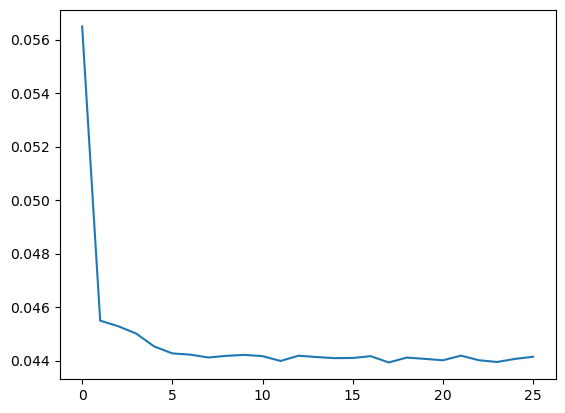

Epoch 025 | Avg Loss: 0.0441 | LR: 0.000053
0 4.2538981169835335
100 4.270488790898555
Epoch 026 | Avg Loss: 0.0440 | LR: 0.000034
0 4.3075626788249775
100 4.178223042070409
Epoch 027 | Avg Loss: 0.0440 | LR: 0.000021
0 4.243160362362087
100 4.309345448057981
Epoch 028 | Avg Loss: 0.0442 | LR: 0.000013
0 4.374876727930167
100 4.447543940231396
Epoch 029 | Avg Loss: 0.0440 | LR: 0.000010
0 4.118821706547644
100 4.230425682279044
Epoch 030 | Avg Loss: 0.0439 | LR: 0.000013
0 4.126424775196991
100 4.165913589961193
Epoch 031 | Avg Loss: 0.0440 | LR: 0.000021
0 4.3315164328026645
100 4.323128483331476
Epoch 032 | Avg Loss: 0.0441 | LR: 0.000034
0 4.350925037343352
100 4.1607622047734445
Epoch 033 | Avg Loss: 0.0440 | LR: 0.000053
0 4.314932618649439
100 4.264167087533348
Epoch 034 | Avg Loss: 0.0441 | LR: 0.000076
0 4.3053882250626625
100 4.247159428624871
Epoch 035 | Avg Loss: 0.0440 | LR: 0.000105
0 4.36402571468334
100 4.215923153399538
Epoch 036 | Avg Loss: 0.0440 | LR: 0.000137
0 4.38

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingLR

EPOCHS = 120
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS//4, eta_min=1e-5) 


model = model.to(device)
# ---- Training loop ----
losses = []
lrs = []
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0
    epoch_losses = []
    for isb, subject_batches in enumerate(loader):
    """ for each batch, we process minibatches per subject separately
    to account for the fact that the input dimensions are different
    (TODO: make this more efficient by standardizing minibatch size per subject)
    """
        loss = 0
        mu_s_subjects = []
        mu_r_subjects = []
        sid_subjects = []
        y_all = []
        for sid, data in subject_batches.items():
            x_batch = data['x']
            y_batch = torch.from_numpy(np.array(data['y'])).to(device)
            
            x_batch = x_batch.to(device)  # (batch, N_CH, SEQ_LEN)
            # Forward
            recon, mu_s, logvar_s, mu_r, logvar_r = model(x_batch, sid)
            
            mu_s_subjects.append(mu_s)
            mu_r_subjects.append(mu_r)
            sid_subjects.extend([int(sid)] * mu_s.size(0))
            y_all.append(y_batch)
            
            # Reconstruction loss
            recon_loss = mse_loss(recon, x_batch)
            
            # KL losses
            kl_s = kl_divergence(mu_s, logvar_s) / (batch_size * seq_len)
            kl_r = kl_divergence(mu_r, logvar_r) / (batch_size * seq_len)

            loss = loss + recon_loss + kl_s + kl_r 
            
        # Total loss
        # Contrastive loss using subject latent (mu_s)
        mu_s = torch.cat(mu_s_subjects, dim=0)  # (total_batch, latent_dim)
        subj_labels = torch.tensor(sid_subjects, device=device)#.reshape(-1, 1)
        subj_cont = contrastive_loss(mu_s, subj_labels)

        # Time-wise contrastive loss (on residual latent)
        mu_r = torch.cat(mu_r_subjects, dim=0)
        y_labels = torch.cat(y_all, dim=0)
        time_cont = time_contrastive_loss(mu_r, y_labels)
        
        # update loss
        loss = loss + 0.1 * (subj_cont + time_cont)
        #loss += orthogonality_loss(mu_s, mu_r)
        loss += decorrelation_loss(mu_r)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # total_loss += loss.item()/x_batch.size(0)
        epoch_losses.append(loss.item())#/x_batch.size(0))
        if isb%100==0: print(isb, loss.item())
        
    avg_loss = sum(epoch_losses)/ len(loader.dataset)
    losses.append(avg_loss)
    scheduler.step() 
    lrs.append(scheduler.get_last_lr()[0])
    if (epoch>0) and (epoch%25==0):
        plt.plot(losses)
        plt.show()
    if epoch % 1 == 0:
        print(f"Epoch {epoch:03d} | Avg Loss: {avg_loss:.4f} | LR: {scheduler.get_last_lr()[0]:.6f}")

plt.plot(losses)
plt.show()
plt.plot(lrs)
plt.show()
# After training, save model
torch.save(model.state_dict(), 'gc_vase_adaptive.pt')

### obtain and visualize latents

In [50]:
def get_latents(model, x, sids, sample=False):
    """Returns (z_s, z_r) for inputs x, using either the posterior mean
       (sample=False) or a random draw (sample=True)."""
    model.eval()
    with torch.no_grad():
        _, mu_s, lv_s, mu_r, lv_r = model(x, sids)
        if sample:
            z_s = model.reparameterize(mu_s, lv_s)
            z_r = model.reparameterize(mu_r, lv_r)
        else:
            z_s, z_r = mu_s, mu_r
    return z_s, z_r

all_zs, all_zr = [], []
all_sids = []
all_labels = []
model.eval()
with torch.no_grad():
    for sid, loader in eval_loaders.items():
        for (x_batch, y_batch, _) in loader:
            z_s, z_r = get_latents(model, x_batch.to(device), sid, sample=False)
            all_zs.append(z_s.cpu())
            all_zr.append(z_r.cpu())
            all_sids.append([sid]*len(z_s))
            all_labels.append(y_batch)
# concatenate back
Z_subject  = torch.cat(all_zs, dim=0)  # (N, latent_s)
Z_residual = torch.cat(all_zr, dim=0)  # (N, latent_r)
all_sids = np.concatenate(all_sids)
all_labels = np.concatenate(all_labels)

In [53]:
import umap

Z_dict = {
    'subject': Z_subject,
    'residual': Z_residual
}

embs = {}
for label, Z in Z_dict.items():
    emb = umap.UMAP(n_neighbors=20, random_state=42).fit_transform(Z)
    embs[label]=emb

/om2/group/fiete/loading/miniconda3/envs/mne/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/om2/group/fiete/loading/miniconda3/envs/mne/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/om2/group/fiete/loading/miniconda3/envs/mne/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/om2/group/fiete/loading/miniconda3/envs/mne/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


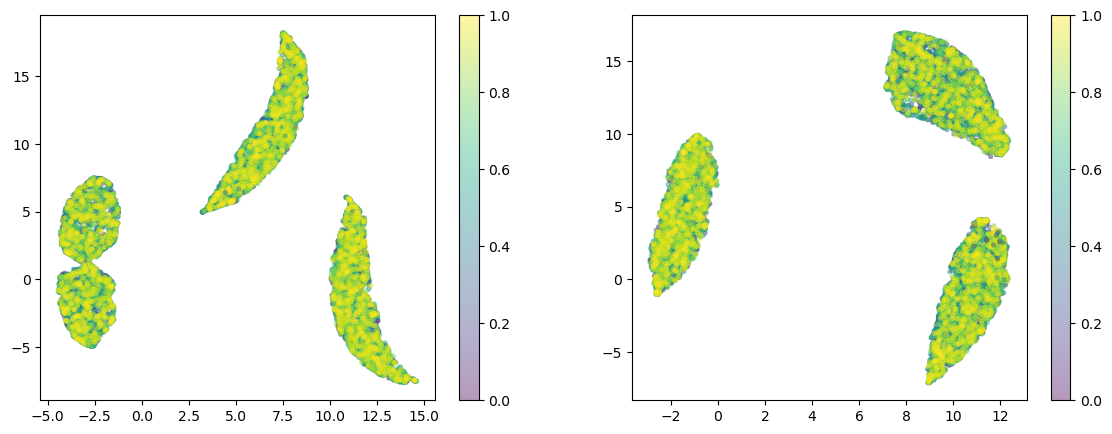

In [54]:
t = all_labels#np.arange(len(emb))
t = t/max(t)

cmap = plt.get_cmap('viridis')
fig, axes = plt.subplots(1, 2, figsize = (14, 5))
for i, emb in enumerate(embs.values()):
    sc = axes[i].scatter(emb[:, 0], emb[:, 1], s = 8, alpha = 0.4, c = cmap(t))
    plt.colorbar(sc, ax = axes[i])
plt.show()

In [55]:
def encode_subject_ids(subject_ids):
    """
    Maps unique subject ID strings to integer labels for colormap use.

    Args:
        subject_ids (list of str): e.g., ['s1', 's3', 's2', 's1', 's3']

    Returns:
        encoded (np.ndarray): integer labels, e.g., [0, 2, 1, 0, 2]
        id_to_int (dict): mapping from original subject ID to integer
        int_to_id (dict): inverse mapping
    """
    unique_ids = sorted(set(subject_ids))  # ensure consistent ordering
    id_to_int = {sid: i for i, sid in enumerate(unique_ids)}
    int_to_id = {i: sid for sid, i in id_to_int.items()}
    encoded = np.array([id_to_int[sid] for sid in subject_ids])
    return encoded, id_to_int, int_to_id

encoded_sids, id_to_int, int_to_id = encode_subject_ids(all_sids)

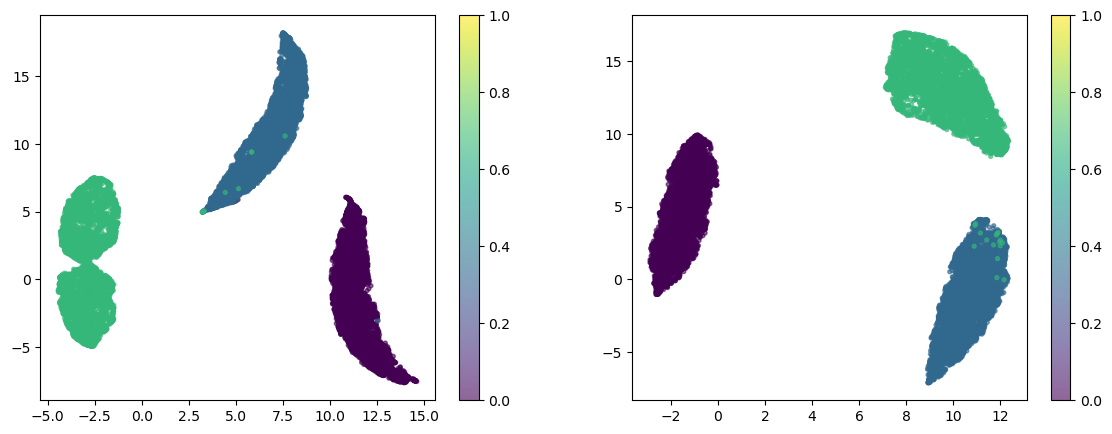

Text(0.5, 0.98, 'colored by time')

<Figure size 640x480 with 0 Axes>

In [56]:
cmap = plt.get_cmap('viridis')
fig, axes = plt.subplots(1, 2, figsize = (14, 5))
for i, emb in enumerate(embs.values()):
    sc = axes[i].scatter(emb[:, 0], emb[:, 1], s = 8, alpha = 0.6, 
                         c = cmap(encoded_sids/3))
    plt.colorbar(sc, ax = axes[i])
plt.show()
plt.suptitle('colored by time')

/tmp/ipykernel_1481397/4101539420.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(points[~mask, 0], points[~mask, 1], c='k',


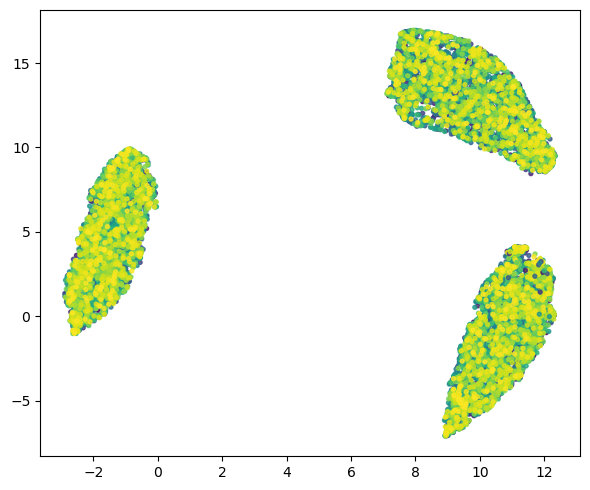

In [57]:
import matplotlib.pyplot as plt
import numpy as np

def scatter_by_label(points, labels, colormap='tab20'):
    colors = all_labels

    cmap = plt.get_cmap(colormap)
    
    fig, ax = plt.subplots(figsize=(6, 5))
    mask = labels!='misc'
    ax.scatter(points[~mask, 0], points[~mask, 1], c='k',
                          s=8, alpha=0.1, cmap=cmap)
    scatter = ax.scatter(points[mask, 0], points[mask, 1], c=colors[mask], 
                          s=8, alpha=0.8, cmap=cmap)

    plt.tight_layout()
    return fig

#for i, emb in enumerate(embs.values()):
emb = embs['residual']
scatter_by_label(emb, all_labels, colormap = 'viridis')
plt.show()

In [58]:
pos_labels = np.tile(data_df['7']['info']['pos'], 3)
concept_labels = np.tile(data_df['7']['info']['concept'], 3)

/tmp/ipykernel_1481397/1304842749.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(points[~mask, 0], points[~mask, 1], c='k',


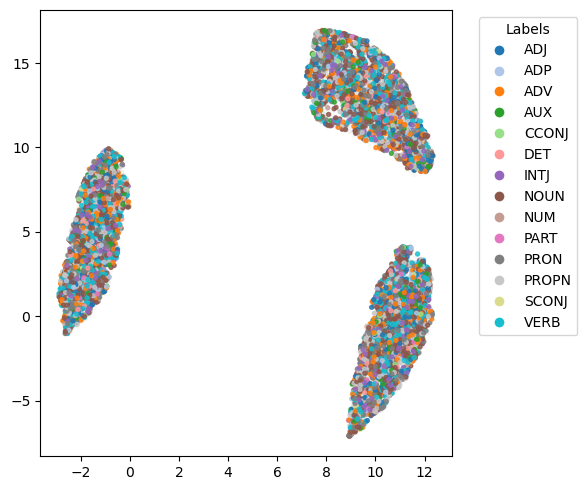

In [59]:
def scatter_by_label(points, labels, colormap='tab20'):
    unique_labels, counts = np.unique(labels, return_counts = True)
    label_to_color = {label: idx for idx, label in enumerate(unique_labels)}
    colors = np.array([label_to_color[label] for label in labels])

    cmap = plt.get_cmap(colormap)
    norm = plt.Normalize(vmin=0, vmax=len(unique_labels) - 1)
    
    fig, ax = plt.subplots(figsize=(6, 5))
    mask = labels!='misc'
    ax.scatter(points[~mask, 0], points[~mask, 1], c='k',
                          s=8, alpha=0.02, cmap=cmap, norm=norm)
    scatter = ax.scatter(points[mask, 0], points[mask, 1], c=colors[mask], 
                          s=8, alpha=0.8, cmap=cmap, norm=norm)

    # Create a legend with label names
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=lbl,
                          markerfacecolor=cmap(norm(idx)), markersize=8)
               for lbl, idx in label_to_color.items() if lbl != 'misc']
    plt.legend(handles=handles, title="Labels", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    return fig

#for i, emb in enumerate(embs.values()):
emb = embs['residual']
scatter_by_label(emb, pos_labels)
plt.show()

/tmp/ipykernel_1481397/1436865769.py:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(points[~mask, 0], points[~mask, 1], c='k',
/tmp/ipykernel_1481397/1436865769.py:33: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


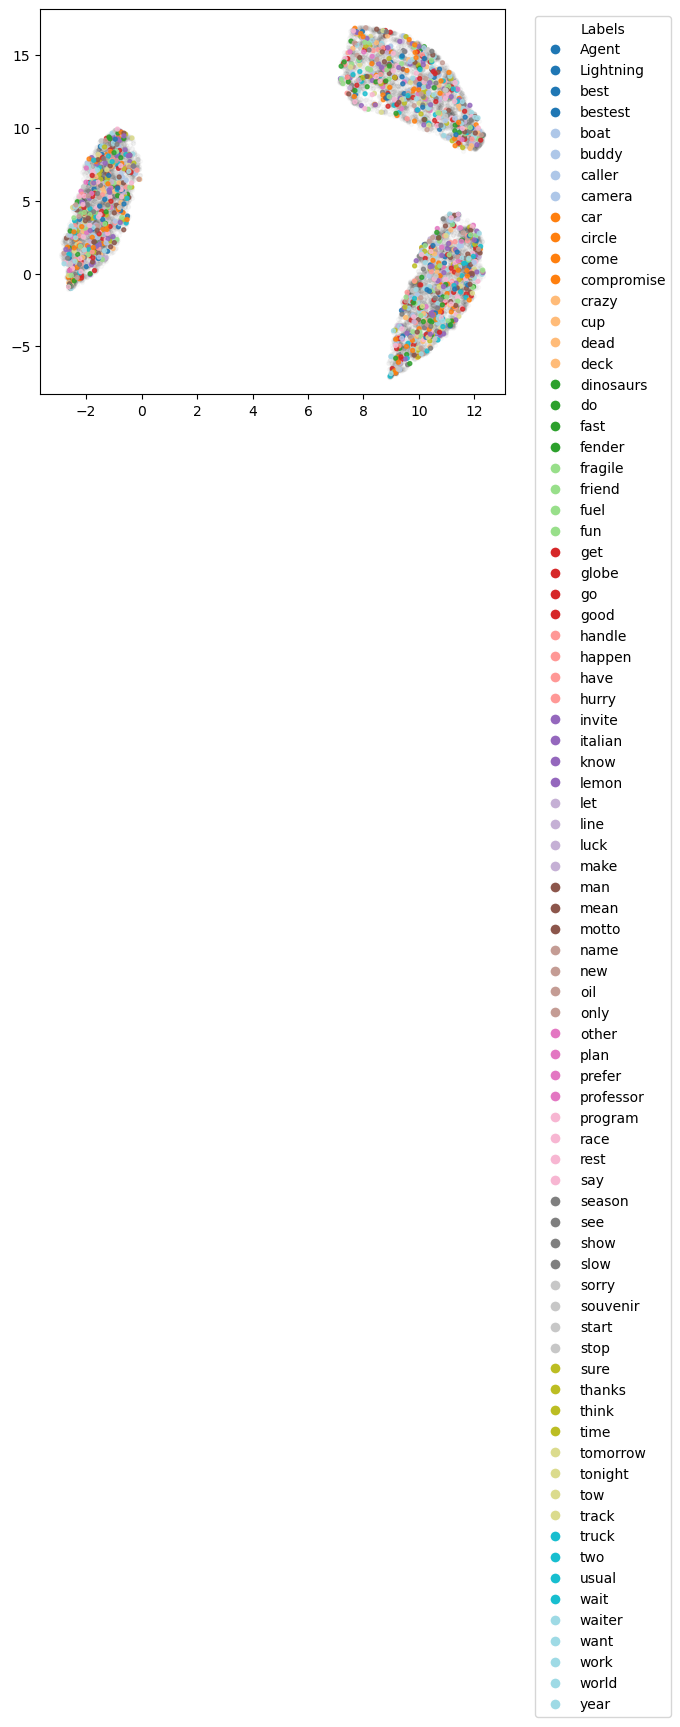

In [60]:
import matplotlib.pyplot as plt
import numpy as np

def scatter_by_label(points, labels, colormap='tab20', min_count = 10):
    unique_labels, counts = np.unique(labels, return_counts = True)
    label_counts = dict(zip(unique_labels, counts))
    
    # Replace infrequent labels with 'misc'
    labels = np.array([
        label if label_counts[label] >= min_count else 'misc' 
        for label in labels
    ])
    
    unique_labels = sorted(set(labels))
    label_to_color = {label: idx for idx, label in enumerate(unique_labels)}
    colors = np.array([label_to_color[label] for label in labels])

    cmap = plt.get_cmap(colormap)
    norm = plt.Normalize(vmin=0, vmax=len(unique_labels) - 1)
    
    fig, ax = plt.subplots(figsize=(6, 5))
    mask = (labels!='misc') & (labels!='other')
    ax.scatter(points[~mask, 0], points[~mask, 1], c='k',
                          s=8, alpha=0.02, cmap=cmap, norm=norm)
    scatter = ax.scatter(points[mask, 0], points[mask, 1], c=colors[mask], 
                          s=8, alpha=0.8, cmap=cmap, norm=norm)

    # Create a legend with label names
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=lbl,
                          markerfacecolor=cmap(norm(idx)), markersize=8)
               for lbl, idx in label_to_color.items() if lbl != 'misc']
    plt.legend(handles=handles, title="Labels", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    return fig

scatter_by_label(emb, concept_labels)
plt.show()